#Utilizando Uma Rede Neural MLP para predição de Câncer

In [0]:
# importando bibliotecas necessárias

%matplotlib inline
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import torch.utils.data as utils
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import seaborn as sn
from sklearn.metrics import confusion_matrix

import torchvision
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import collections

import torch.nn as nn
from torch.autograd import Variable
import torch
import torch.utils.data as utils

In [0]:
# carregar o dataset

raw_data = pd.read_csv('breast-cancer-wisconsin.data')
raw_data.head()

,id,thickness,uni cell size,uni cell shape,adhesion,cell size,bare nuclei,chromatin,normal nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [0]:
# remover colunas não relevantes

data = raw_data.drop(["id"], axis= 1)
data.head()

,thickness,uni cell size,uni cell shape,adhesion,cell size,bare nuclei,chromatin,normal nucleoli,mitoses,class
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


In [0]:
print("The number of rows in X are {}".format(len(data)))

The number of rows in X are 683


In [0]:
# descartar dados indefinidos

#data = data[~data[6].isin(['?'])]
print("The number of rows in X are {}".format(len(data)))

The number of rows in X are 683


In [0]:
# criando dados x e y

data_x = data.loc[:, data.columns != "class"]
data_y = data.loc[:, data.columns == "class"]

#making sure everything is ok
print("The number of rows in X are {}".format(len(data_x)))
print("The number of rows in Y are {}".format(len(data_y)))

The number of rows in X are 683
The number of rows in Y are 683


In [0]:
# criando arrays numpy
data_id_x = data_x.iloc[:,:].values
data_id_y = data_y.iloc[:,:].values
 
print(data_id_x[0:7])
print(data_id_y[0:7])

[[ 5  1  1  1  2  1  3  1  1]
 [ 5  4  4  5  7 10  3  2  1]
 [ 3  1  1  1  2  2  3  1  1]
 [ 6  8  8  1  3  4  3  7  1]
 [ 4  1  1  3  2  1  3  1  1]
 [ 8 10 10  8  7 10  9  7  1]
 [ 1  1  1  1  2 10  3  1  1]]
[[2]
 [2]
 [2]
 [2]
 [2]
 [4]
 [2]]


In [0]:
# normalizando valores

scaler = StandardScaler()
data_id_x = scaler.fit_transform(data_id_x)
 
print(data_id_x[:5])

[[ 0.19790469 -0.70221201 -0.74177362 -0.63936553 -0.5556085  -0.69885309
  -0.18182716 -0.61292736 -0.34839971]
 [ 0.19790469  0.27725185  0.26278299  0.75803177  1.69516613  1.77286724
  -0.18182716 -0.28510482 -0.34839971]
 [-0.51164337 -0.70221201 -0.74177362 -0.63936553 -0.5556085  -0.4242175
  -0.18182716 -0.61292736 -0.34839971]
 [ 0.55267873  1.58320366  1.6021918  -0.63936553 -0.10545357  0.12505369
  -0.18182716  1.3540079  -0.34839971]
 [-0.15686934 -0.70221201 -0.74177362  0.05933312 -0.5556085  -0.69885309
  -0.18182716 -0.61292736 -0.34839971]]


In [0]:
# dividir dataset em teste e treino

X_train, X_test, Y_train, Y_test = train_test_split(data_id_x, data_id_y, test_size = 0.2)

print("X_Train", X_train.dtype, len(X_train))
print("Y_Train", Y_train.dtype, len(Y_train))
print("X_Test", X_test.dtype, len(X_test))
print("Y_Test", Y_test.dtype, len(Y_test))

X_Train float64 546
Y_Train int64 546
X_Test float64 137
Y_Test int64 137


In [0]:
#Try to convert numpy to torch Tensors



X_train_T = torch.from_numpy(X_train.astype("float32", casting="same_kind"))
X_test_T = torch.from_numpy(X_test.astype("float32", casting="same_kind"))
Y_train_T = torch.from_numpy(Y_train.astype("float32"))
Y_test_T = torch.from_numpy(Y_test.astype("float32"))

#now lets create the training tensor dataset

X_Dataset = utils.TensorDataset(X_train_T, Y_train_T)
Y_Dataset = utils.TensorDataset(X_test_T, Y_test_T)

In [0]:
# criando dataloader

batch_size = 1
train_loader = utils.DataLoader(dataset=X_Dataset, batch_size = batch_size, shuffle = True)
test_loader = utils.DataLoader(dataset=Y_Dataset, batch_size=batch_size, shuffle=True)


# checa se dataloader é iterável

print(isinstance(train_loader, collections.Iterable))
print(isinstance(test_loader, collections.Iterable))

True
True


Benign: 444
Malignant: 239
Proportion: 1.86 : 1


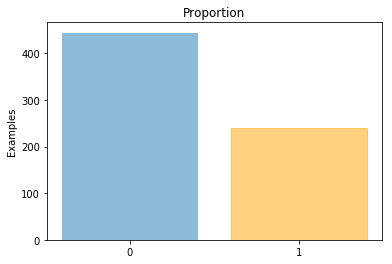

In [0]:
# checagem de proporção

benign_dataset = data.loc[data.loc[:, 'class'] == 2]
malignant_dataset = data.loc[data.loc[:, 'class'] == 4]

benign = benign_dataset.count()[0]
malignant = malignant_dataset.count()[0]

print('Benign:', benign)
print('Malignant:', malignant)
print('Proportion:', round(benign / malignant, 2), ': 1')

target_count = []
target_count.append(benign)
target_count.append(malignant)

barlist = plt.bar([0, 1], target_count, align='center', alpha=0.5)
barlist[1].set_color('orange')
plt.xticks([0, 1])
plt.ylabel('Examples')
plt.title('Proportion')
plt.show()

In [0]:
# definindo a arquitetura MLP

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(9, 18)
        self.fc2 = nn.Linear(18, 9)
        self.fc3 = nn.Linear(9, 1)

        self.activation_function = nn.ReLU()
    def forward(self, x):
        x = x.view(-1, 9)
        x = self.activation_function(self.fc1(x))
        x = self.activation_function(self.fc2(x))
        x = self.activation_function(self.fc3(x))
        return x
    

In [0]:
# instanciando o modelo

model = MLP()
#model.cuda()
print(model)

# definindo otimizador e loss

optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
#loss_fn = nn.CrossEntropyLoss()

# outros otimizadores
loss_fn = torch.nn.MSELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

MLP(
  (fc1): Linear(in_features=9, out_features=18, bias=True)
  (fc2): Linear(in_features=18, out_features=9, bias=True)
  (fc3): Linear(in_features=9, out_features=1, bias=True)
  (activation_function): ReLU()
)


In [0]:
# realizando o treinamento

epochs = 100
train_losses = []
running_losses_list = []
train_accuracy_list = []
#alpha = 0.001


for epoch in range(epochs):
    model.train()
    i = 0
    running_loss = 0.0
    accuracy = 0.0
    total = 0
    correct = 0
    
    
    for x, y in train_loader:
        X = Variable(x)
        Y = Variable(y)
        optimizer.zero_grad()
        
        outputs = model(X)
        predicted = outputs.item()
        #print(predicted)
        
        loss = loss_fn(outputs, Y)

        loss.backward()
        optimizer.step()
        
        i += 1
        
        train_losses.append(loss.item())
        running_loss += loss.item()
        
        #print(Y, outputs.data)
        #print(type(outputs))
        #print(outputs.data)
        
        if predicted >= 3:
            predicted = 4
        else:
            predicted = 2
        
        total += Y.size(0)

        if Y == predicted:
            #print('acertou')
            correct+=1
        #else:
            #print('errou')
        
    accuracy = correct / total * 100
    train_accuracy_list.append(accuracy)    
    running_losses_list.append(running_loss)
    print("Epoch: %5d \t Loss: %.5f \t Accuracy: %.5f %%" %(epoch+1,running_loss, accuracy))

Epoch:     1 	 Loss: 245.97218 	 Accuracy: 93.22344 %
Epoch:     2 	 Loss: 81.73430 	 Accuracy: 96.88645 %
Epoch:     3 	 Loss: 69.21997 	 Accuracy: 97.06960 %
Epoch:     4 	 Loss: 58.26564 	 Accuracy: 97.61905 %
Epoch:     5 	 Loss: 50.20785 	 Accuracy: 97.43590 %
Epoch:     6 	 Loss: 47.81236 	 Accuracy: 97.61905 %
Epoch:     7 	 Loss: 43.10653 	 Accuracy: 97.98535 %
Epoch:     8 	 Loss: 40.29929 	 Accuracy: 98.16850 %
Epoch:     9 	 Loss: 39.74462 	 Accuracy: 98.16850 %
Epoch:    10 	 Loss: 38.82437 	 Accuracy: 98.16850 %
Epoch:    11 	 Loss: 35.44846 	 Accuracy: 97.80220 %
Epoch:    12 	 Loss: 35.20350 	 Accuracy: 98.35165 %
Epoch:    13 	 Loss: 34.99226 	 Accuracy: 98.16850 %
Epoch:    14 	 Loss: 33.89022 	 Accuracy: 98.53480 %
Epoch:    15 	 Loss: 33.30916 	 Accuracy: 98.35165 %
Epoch:    16 	 Loss: 32.41558 	 Accuracy: 98.35165 %
Epoch:    17 	 Loss: 32.77015 	 Accuracy: 98.53480 %
Epoch:    18 	 Loss: 32.92349 	 Accuracy: 98.16850 %
Epoch:    19 	 Loss: 29.38786 	 Accuracy: 98.

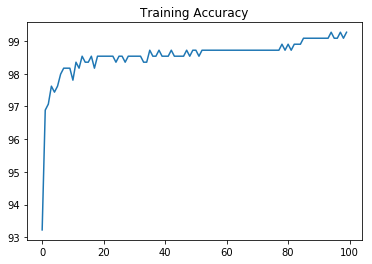

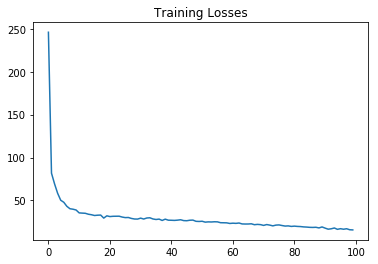

In [0]:
# plot dos resultados
plt.plot(train_accuracy_list, label='')
plt.title("Training Accuracy")
plt.show()

plt.plot(running_losses_list, label='')
plt.title("Training Losses")
plt.show()


In [0]:
# avaliando o modelo aqui (no conjunto de validação) (ou teste, caso entrega)

test_losses = []
test_accuracies = []
y_pred = []
y_true = []

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for x, y in test_loader: #validation_loader
        X = Variable(x)
        Y = Variable(y)
        
        outputs = model(X)
        predicted = outputs.item()

        loss = loss_fn(outputs, Y)# + alpha * regularization_loss
        
        test_losses.append(loss.item())

        if predicted >= 3:
            predicted = 4
        else:
            predicted = 2
            
        total += Y.size(0)
        if Y == predicted:
            #print('acertou')
            correct+=1
        
        if Y == 4:
            y_true.append(4)
        else:
            y_true.append(2)
        
        y_pred.append(predicted)
        
accuracy = correct / total

#test_accuracies.append(accuracy)
print("Epoch: %5d \t Loss: %.5f \t Accuracy: %.2f %%" %(epoch+1, sum(test_losses), accuracy*100))

Epoch:   100 	 Loss: 25.69714 	 Accuracy: 95.62 %


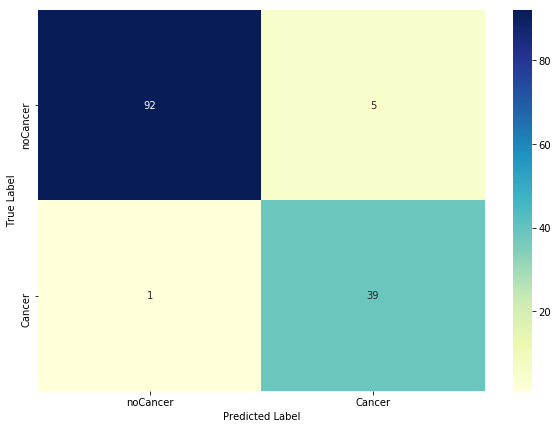

In [0]:
# plottando a tabela de contingência

cm = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cm, index=('noCancer', 'Cancer'), columns=('noCancer', 'Cancer'))
plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True, cmap=plt.cm.YlGnBu, fmt='d')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Relatório

---
Utilizando Pandas para ler o dataset, removemos as colunas não relevantes para o problema(como id), convertemos o dataset para arrays numpy, normalizamos o dataset para evitar explosão de gradiente e valores tendenciosos, dividimos o dataset em teste e treino(20% teste, 80% treino), convertemos os arrays para tensores de dados do Pytorch e então para DataLoaders, para iterar pelos dados durante treino e teste.

---

Utilizamos uma MLP de duas camadas ocultas, com 9 neurônios de entrada, 18 na primeira camada oculta, 9 na segunda camada oculta e 1 na saída. Ela é Fully Connected. Utilizamos ReLU como função de ativação(ela propicia dropout natural e evita vanishing gradient). Treinamos por 100 épocas. Utilizamos MSE (lr = 0.001, momentum = 0.9) como função de loss e SGD como otimizador.

---

Como resultados obtivemos loss de 15.61 na última época do treinamento e acurácia de 99.26%.


No conjunto de testes, obtivemos loss de 25.69  e acurácia de 95.62%.


---
Redes com arquiteturas mais complexas tendem a causar overfit dos dados. E esta foi uma das redes simples que testamos que ainda se mostrou representativa. 

---
Alunos: Alexandre Bender, Victor Grovermann, Moniele Santos, Vinicius Borges, Rafael Ferreira